## Setup

In [380]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

from parth import *

from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya, loadMCSamples
from getdist import gaussian_mixtures
import getdist.plots as gdplt

from numpy import loadtxt, savetxt, mgrid, argwhere, c_, arange, linspace, reshape
from sympy import symbols, diff, lambdify
from itertools import combinations

from matplotlib.axes import Axes

%matplotlib inline

gdplot = gdplt.get_subplot_plotter()

In [381]:
plt.rcParams.update({"text.usetex": True,"font.family": "serif"})
myColors = ['C1', 'C2', 'C4', 'C3']

### Params

In [382]:
tau_prior = 0.5
# slurm_id=37940595
slurm_id=37940610
#slurm_id=37890475
job = f'BBN_small_eta10'

#gparams = ['omega_b_h2', 'N_nu', 'tau']
gparams = ['eta10', 'N_nu', 'tau']
removeParams = []
fixedParams = {}

experiment = 0
spectrum = 'unlensed'
priorWidth = 1
useDali = True
save_pdf = True
cobaya_debug = False

inc_base='/users/stevensonb/scratch/tmp/chains/incomplete'
fin_base='/users/stevensonb/Research/DALI/chains'

i = 0 if tau_prior == 0.5 else tau_prior

if os.path.exists(f'{fin_base}/complete/{job}/{slurm_id}/{i}/'):
    exact_chain_path = f'{fin_base}/complete/{job}/{slurm_id}/{i}/{i}'
elif os.path.exists(f'{inc_base}/{job}/{slurm_id}/{i}/'):
    exact_chain_path=f'{inc_base}/{job}/{slurm_id}/{i}/{i}'
else:
    print(f'Could not find chain for {job} {slurm_id} {i}')
    assert False

print(f'Loading chain from {exact_chain_path}')

Loading chain from /users/stevensonb/Research/DALI/chains/complete/BBN_small_eta10/37940610/15/15


## Functions

In [383]:
latex_trans = {
    'omega_c_h2':r'\Omega_\mathrm{cdm}h^2', 
    'omega_b_h2':r'\Omega_b h^2', 
    'N_eff':r'N_\mathrm{eff}',
    'N_nu':r'N_\mathrm{eff}', # Just for the effect
    'A_s':r'A_\mathrm{s}', 
    'n_s':r'n_\mathrm{s}', 
    'theta_s':r'\theta_\mathrm{s}',
    'tau':r'\tau_n\;[s]',
    'mnu':r'm_\mathrm{\nu}',
    'eta10':r'\eta_\mathrm{10}'
}

def get_data(file=job + '.pkl', fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params = {}
    with open(file, 'rb') as f:
        data = pickle.load(f)

    fid = data['cosmoFid']
    fisher = data['fisherGaussian'][experiment][spectrum]
    
    if remove_params:
        for k in remove_params:
            i = list(fid.keys()).index(k)
            fid.pop(k)
            fisher = np.delete(np.delete(fisher, i, 0), i, 1)

    inv = np.linalg.inv(fisher)
    
    widths = [prior_width * i for i in [1.25, 1.25, 200]]

    for i, (k, v) in enumerate(fid.items()):
        if k not in fixed_params:
            if k == 'tau':
                val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'loc': v, 'scale': tau_prior, 'dist': 'norm'}}
            else:
                val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'min': v-widths[i], 'max':v+widths[i]}}
            params.update({k: val})
        else:
            params.update({k: {'value': fixed_params[k], 'latex': latex_trans.get(k, k)}})
            
    return params, fid, inv

def get_model(use_dali=useDali, file=job + '.pkl', fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params, cosmoFid, cov = get_data(file, fixed_params, remove_params, experiment, spectrum, prior_width)
    
    model = {
        'debug': cobaya_debug,
        'likelihood': {
            'dali': { 
                'python_path': 'likelihoods/dali',
                'use_dali': use_dali,
                'file': file,
                'remove': removeParams,
                'experiment': experiment,
                'spectrum': spectrum,
                'tau_prior': tau_prior
            }
        },
        'params': params,
        'sampler': {
            'mcmc': {
                # 'covmat_params': list(params.keys()),
                # 'covmat': cov,
                'oversample_power': 0.8,
                'proposal_scale': 1.5,
                'Rminus1_stop': 0.005,
                'Rminus1_cl_stop': 0.02,
                'max_tries': 1000,
            }
        }
    }
    return model

"""
Created on Tuesday, July 26, 2022, at 01:23 PM

@author: Joe Ryan and Cynthia Trendafilova
Modifications by: Brandon Stevenson
"""
def add_KBBN(plotter, 
bounds, 
grid_order = list(combinations(range(0, 3), r=2)), 
plot_order = list(combinations(range(0, 3), r=2)),
contour_levels = [0, 2.3, 6.17], 
data_file = job + '.pkl',
lws=[1, 1, 1],
colors=myColors,
exp=experiment, 
spec=spectrum,
grid_size=16j,
linspace_size=50,
alphas=[0.5,0.5,1]
):
    """
    Note: girid_order and plot_order must be the same length
    """

    with open(data_file, 'rb') as f:
        data_BBN = pickle.load(f)
    
    fid = data_BBN['cosmoFid']
    F = data_BBN['fisherGaussian'][exp][spec]
    G = data_BBN['DALI3Gaussian'][exp][spec]
    H = data_BBN['DALI4Gaussian'][exp][spec]
    
    x = symbols('x', real=True)
    y = symbols('y', real=True)

    p_names = list(fid.keys())
    p_fid = list(fid.values())

    for q in range(0, len(plot_order), 1):        
        i = plot_order[q][0]
        j = plot_order[q][1]
        ij = [i, j]
        
        p = [x - p_fid[i], y - p_fid[j]]
        
        sumF = (-1/2)*(F[i][i]*p[0]*p[0] + F[i][j]*p[0]*p[1] + F[j][i]*p[1]*p[0] + F[j][j]*p[1]*p[1])
        sumG = 0
        sumH = 0
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    sumG += (-1/2)*G[ij[a]][ij[b]][ij[c]]*p[a]*p[b]*p[c]
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    for d in range(0, 2, 1):
                        sumH += (-1/8)*H[ij[a]][ij[b]][ij[c]][ij[d]]*p[a]*p[b]*p[c]*p[d]
                        
        Phi = -(sumF + sumG + sumH)
        
        Phi0 = diff(Phi, x)
        Phi1 = diff(Phi, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_D = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeD = argwhere(K_D <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeD)
    
        ### Sanity check:
        Phi_F = -sumF
        
        Phi0 = diff(Phi_F, x)
        Phi1 = diff(Phi_F, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_F = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeF = argwhere(K_F <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_Fisher_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeF)
        
        #if len(negativeD) != 0:
        X0 = []
        X1 = []
        
        for u in arange(0, len(negativeD), 1):
            I0 = negativeD[u][0]
            I1 = negativeD[u][1]
            
            X0.append(x0[I0][I1])
            X1.append(x1[I0][I1])
            
        ### Save coordinates:
        # savetxt('coords_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', c_[X0, X1])
    
        ### Plot coordinates at which K <= 0 over Fisher and Doublet cross-section contours:
       
        X = linspace(bounds[i][0], bounds[i][1], linspace_size)
        Y = linspace(bounds[j][0], bounds[j][1], linspace_size)
        
        Z = []
        Z_F = []
        xl = []
        yl = []
        
        Phi_L = lambdify([x, y], Phi)
        Phi_FL = lambdify([x, y], Phi_F)
        for xc0 in X:
            for xc1 in Y:
                Z.append(Phi_L(xc0, xc1))
                Z_F.append(Phi_FL(xc0, xc1))
                xl.append(xc0)
                yl.append(xc1)    

        x_2d = reshape(xl, (linspace_size, linspace_size))
        y_2d = reshape(yl, (linspace_size, linspace_size))
        z_2d = reshape(Z, (linspace_size, linspace_size))
        zf_2d = reshape(Z_F, (linspace_size, linspace_size))

        ax = plotter.get_axes(grid_order[q])

        # set labels in accordance with plotter style
        lab_fontsize = plotter._scaled_fontsize(plotter.settings.axes_labelsize)
        ax.set_xlabel('$'+latex_trans.get(p_names[i], p_names[i])+'$',  fontsize=lab_fontsize, verticalalignment='baseline', labelpad=4 + lab_fontsize)
        ax.set_ylabel('$'+latex_trans.get(p_names[j] , p_names[j])+'$', fontsize=lab_fontsize)

        tick_label_size = plotter._scaled_fontsize(None, plotter.settings.axes_fontsize)
        ax.tick_params(which='major', labelsize=tick_label_size)
        # ax.get_offset_text().set_fontsize(tick_label_size * 3 / 4 if tick_label_size > 7 else tick_label_size)

        ax.set_xlim(bounds[i][0], bounds[i][1])
        ax.set_ylim(bounds[j][0], bounds[j][1])
        
        ax.contour(x_2d, y_2d, zf_2d, contour_levels, colors=colors[2], linestyles='dotted', zorder=1, linewidths=lws, alpha=alphas[0]).collections[0].set_label('Fisher') # fisher
        ax.contour(x_2d, y_2d, z_2d, contour_levels, colors=colors[1], linestyles='dashed', zorder=2, linewidths=lws, alpha=alphas[1]).collections[0].set_label('Doublet') 
        ax.scatter(X0, X1, marker='.', color=colors[3], zorder=3, label='Concavity', alpha=alphas[2])

## Progress Report

In [384]:
from cobaya.samplers.mcmc import plot_progress

id=slurm_id

#id=37940595
id=37940610

chain_loc=f'{inc_base}/{job}/{id}'
# chain_loc=f'{fin_base}/complete/{job}/{slurm_id}'
# chain_loc=f'{fin_base}/failed/{job}/{slurm_id}'

for i in [0,1,5,10,15,30]:
    path = f'{chain_loc}/{i}'
    if os.path.exists(path):
        plot_progress(f'{path}/{i}')
        plt.title(f'Chain {i}')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Chain {i} does not exist at {path}')

Chain 0 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/37940610/0
Chain 1 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/37940610/1
Chain 5 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/37940610/5
Chain 10 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/37940610/10
Chain 15 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/37940610/15
Chain 30 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/37940610/30


## Analysis

### Generator

In [385]:
%%capture

gdsExact = loadMCSamples(exact_chain_path)
gdsExact.name_tag = 'Exact'

with open(job + '.pkl', 'rb') as f: 
    data = pickle.load(f)  
fisher = data['fisherGaussian'][experiment][spectrum]
fisher[2,2] += (1/tau_prior**2)
inv = np.linalg.inv(fisher)
fid = data['cosmoFid']

aFisher = gaussian_mixtures.GaussianND(list(fid.values()), inv, label='Fisher', names=list(fid.keys()), labels=[f'${latex_trans.get(k, k)}$' for k in fid.keys()])

updatedDali, samplerDali = run(get_model(use_dali=True));
gdsDali = MCSamplesFromCobaya(updatedDali, samplerDali.products()["sample"], name_tag='Doublet');

INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {dali: 3820.0}


[model] Setting measured speeds (per sec): {dali: 3820.0}


[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Initial point: eta10:6.13832, N_nu:3, tau:879.4


[mcmc] Initial point: eta10:6.13832, N_nu:3, tau:879.4


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2022-10-23 11:59:40 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2022-10-23 11:59:40 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 120 samples accepted.


[mcmc] Learn + convergence test @ 120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 1.074117 after 96 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.074117 after 96 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.249


[mcmc]  - Acceptance rate: 0.249


INFO:mcmc: - Convergence of means: R-1 = 0.506728 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.506728 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360 samples accepted.


[mcmc] Learn + convergence test @ 360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.359


[mcmc]  - Acceptance rate: 0.359


INFO:mcmc: - Convergence of means: R-1 = 0.318032 after 288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.318032 after 288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.437


[mcmc]  - Acceptance rate: 0.437


INFO:mcmc: - Convergence of means: R-1 = 0.417227 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.417227 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 600 samples accepted.


[mcmc] Learn + convergence test @ 600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.508


[mcmc]  - Acceptance rate: 0.508


INFO:mcmc: - Convergence of means: R-1 = 0.162907 after 480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162907 after 480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.481


[mcmc]  - Acceptance rate: 0.481


INFO:mcmc: - Convergence of means: R-1 = 0.149740 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149740 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 840 samples accepted.


[mcmc] Learn + convergence test @ 840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.482


[mcmc]  - Acceptance rate: 0.482


INFO:mcmc: - Convergence of means: R-1 = 0.259389 after 672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.259389 after 672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.479


[mcmc]  - Acceptance rate: 0.479


INFO:mcmc: - Convergence of means: R-1 = 0.116120 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116120 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1080 samples accepted.


[mcmc] Learn + convergence test @ 1080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.471


[mcmc]  - Acceptance rate: 0.471


INFO:mcmc: - Convergence of means: R-1 = 0.048516 after 864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048516 after 864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.467


[mcmc]  - Acceptance rate: 0.467


INFO:mcmc: - Convergence of means: R-1 = 0.086853 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086853 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1320 samples accepted.


[mcmc] Learn + convergence test @ 1320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.467


[mcmc]  - Acceptance rate: 0.467


INFO:mcmc: - Convergence of means: R-1 = 0.083596 after 1056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083596 after 1056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.456


[mcmc]  - Acceptance rate: 0.456


INFO:mcmc: - Convergence of means: R-1 = 0.052528 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052528 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1560 samples accepted.


[mcmc] Learn + convergence test @ 1560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.457


[mcmc]  - Acceptance rate: 0.457


INFO:mcmc: - Convergence of means: R-1 = 0.044110 after 1248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044110 after 1248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1680 samples accepted.


[mcmc] Learn + convergence test @ 1680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.456


[mcmc]  - Acceptance rate: 0.456


INFO:mcmc: - Convergence of means: R-1 = 0.054694 after 1344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054694 after 1344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1800 samples accepted.


[mcmc] Learn + convergence test @ 1800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.453


[mcmc]  - Acceptance rate: 0.453


INFO:mcmc: - Convergence of means: R-1 = 0.027692 after 1440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027692 after 1440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.447


[mcmc]  - Acceptance rate: 0.447


INFO:mcmc: - Convergence of means: R-1 = 0.025054 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025054 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2040 samples accepted.


[mcmc] Learn + convergence test @ 2040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.444


[mcmc]  - Acceptance rate: 0.444


INFO:mcmc: - Convergence of means: R-1 = 0.032438 after 1632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032438 after 1632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2160 samples accepted.


[mcmc] Learn + convergence test @ 2160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.443


[mcmc]  - Acceptance rate: 0.443


INFO:mcmc: - Convergence of means: R-1 = 0.038394 after 1728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038394 after 1728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2280 samples accepted.


[mcmc] Learn + convergence test @ 2280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.442


[mcmc]  - Acceptance rate: 0.442


INFO:mcmc: - Convergence of means: R-1 = 0.029045 after 1824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029045 after 1824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.436


[mcmc]  - Acceptance rate: 0.436


INFO:mcmc: - Convergence of means: R-1 = 0.037833 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037833 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2520 samples accepted.


[mcmc] Learn + convergence test @ 2520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.432


[mcmc]  - Acceptance rate: 0.432


INFO:mcmc: - Convergence of means: R-1 = 0.018087 after 2016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018087 after 2016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2640 samples accepted.


[mcmc] Learn + convergence test @ 2640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.429


[mcmc]  - Acceptance rate: 0.429


INFO:mcmc: - Convergence of means: R-1 = 0.022056 after 2112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022056 after 2112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2760 samples accepted.


[mcmc] Learn + convergence test @ 2760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.429


[mcmc]  - Acceptance rate: 0.429


INFO:mcmc: - Convergence of means: R-1 = 0.029487 after 2208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029487 after 2208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.430


[mcmc]  - Acceptance rate: 0.430


INFO:mcmc: - Convergence of means: R-1 = 0.027199 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027199 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3000 samples accepted.


[mcmc] Learn + convergence test @ 3000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.431


[mcmc]  - Acceptance rate: 0.431


INFO:mcmc: - Convergence of means: R-1 = 0.028203 after 2400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028203 after 2400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3120 samples accepted.


[mcmc] Learn + convergence test @ 3120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.431


[mcmc]  - Acceptance rate: 0.431


INFO:mcmc: - Convergence of means: R-1 = 0.021370 after 2496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021370 after 2496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3240 samples accepted.


[mcmc] Learn + convergence test @ 3240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.430


[mcmc]  - Acceptance rate: 0.430


INFO:mcmc: - Convergence of means: R-1 = 0.018626 after 2592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018626 after 2592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.431


[mcmc]  - Acceptance rate: 0.431


INFO:mcmc: - Convergence of means: R-1 = 0.019076 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019076 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3480 samples accepted.


[mcmc] Learn + convergence test @ 3480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.433


[mcmc]  - Acceptance rate: 0.433


INFO:mcmc: - Convergence of means: R-1 = 0.010841 after 2784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010841 after 2784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.431


[mcmc]  - Acceptance rate: 0.431


INFO:mcmc: - Convergence of means: R-1 = 0.011648 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011648 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3720 samples accepted.


[mcmc] Learn + convergence test @ 3720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.431


[mcmc]  - Acceptance rate: 0.431


INFO:mcmc: - Convergence of means: R-1 = 0.015407 after 2976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015407 after 2976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.432


[mcmc]  - Acceptance rate: 0.432


INFO:mcmc: - Convergence of means: R-1 = 0.009290 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009290 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3960 samples accepted.


[mcmc] Learn + convergence test @ 3960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.430


[mcmc]  - Acceptance rate: 0.430


INFO:mcmc: - Convergence of means: R-1 = 0.014317 after 3168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014317 after 3168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4080 samples accepted.


[mcmc] Learn + convergence test @ 4080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.429


[mcmc]  - Acceptance rate: 0.429


INFO:mcmc: - Convergence of means: R-1 = 0.013619 after 3264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013619 after 3264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4200 samples accepted.


[mcmc] Learn + convergence test @ 4200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.429


[mcmc]  - Acceptance rate: 0.429


INFO:mcmc: - Convergence of means: R-1 = 0.022333 after 3360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022333 after 3360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.428


[mcmc]  - Acceptance rate: 0.428


INFO:mcmc: - Convergence of means: R-1 = 0.024663 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024663 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4440 samples accepted.


[mcmc] Learn + convergence test @ 4440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.426


[mcmc]  - Acceptance rate: 0.426


INFO:mcmc: - Convergence of means: R-1 = 0.020407 after 3552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020407 after 3552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4560 samples accepted.


[mcmc] Learn + convergence test @ 4560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.008703 after 3648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008703 after 3648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4680 samples accepted.


[mcmc] Learn + convergence test @ 4680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.004932 after 3744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004932 after 3744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005813 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005813 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4920 samples accepted.


[mcmc] Learn + convergence test @ 4920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005887 after 3936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005887 after 3936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5040 samples accepted.


[mcmc] Learn + convergence test @ 5040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005126 after 4032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005126 after 4032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5160 samples accepted.


[mcmc] Learn + convergence test @ 5160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.002577 after 4128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002577 after 4128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.003960 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003960 after 4224 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.060873 after 5280 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.060873 after 5280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5400 samples accepted.


[mcmc] Learn + convergence test @ 5400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.013367 after 4320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013367 after 4320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5520 samples accepted.


[mcmc] Learn + convergence test @ 5520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.011422 after 4416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011422 after 4416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5640 samples accepted.


[mcmc] Learn + convergence test @ 5640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.008385 after 4512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008385 after 4512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.005327 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005327 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5880 samples accepted.


[mcmc] Learn + convergence test @ 5880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.008688 after 4704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008688 after 4704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005524 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005524 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6120 samples accepted.


[mcmc] Learn + convergence test @ 6120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.006077 after 4896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006077 after 4896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.004298 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004298 after 4992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6360 samples accepted.


[mcmc] Learn + convergence test @ 6360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.006751 after 5088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006751 after 5088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6480 samples accepted.


[mcmc] Learn + convergence test @ 6480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.007583 after 5184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007583 after 5184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6600 samples accepted.


[mcmc] Learn + convergence test @ 6600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.008724 after 5280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008724 after 5280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.008824 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008824 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6840 samples accepted.


[mcmc] Learn + convergence test @ 6840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.006672 after 5472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006672 after 5472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6960 samples accepted.


[mcmc] Learn + convergence test @ 6960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005211 after 5568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005211 after 5568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7080 samples accepted.


[mcmc] Learn + convergence test @ 7080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.007246 after 5664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007246 after 5664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.013254 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013254 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7320 samples accepted.


[mcmc] Learn + convergence test @ 7320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.008867 after 5856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008867 after 5856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7440 samples accepted.


[mcmc] Learn + convergence test @ 7440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.006029 after 5952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006029 after 5952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7560 samples accepted.


[mcmc] Learn + convergence test @ 7560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.003038 after 6048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003038 after 6048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.003377 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003377 after 6144 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.061427 after 7680 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.061427 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7800 samples accepted.


[mcmc] Learn + convergence test @ 7800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.004924 after 6240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004924 after 6240 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.071239 after 7800 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.071239 after 7800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7920 samples accepted.


[mcmc] Learn + convergence test @ 7920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.004280 after 6336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004280 after 6336 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.068017 after 7920 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.068017 after 7920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8040 samples accepted.


[mcmc] Learn + convergence test @ 8040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002932 after 6432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002932 after 6432 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.065580 after 8040 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.065580 after 8040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002819 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002819 after 6528 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.064318 after 8160 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.064318 after 8160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8280 samples accepted.


[mcmc] Learn + convergence test @ 8280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.003645 after 6624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003645 after 6624 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.072540 after 8280 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.072540 after 8280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.004605 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004605 after 6720 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.083022 after 8400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.083022 after 8400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8520 samples accepted.


[mcmc] Learn + convergence test @ 8520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.004165 after 6816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004165 after 6816 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.077173 after 8520 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.077173 after 8520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.003939 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003939 after 6912 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.067476 after 8640 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.067476 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8760 samples accepted.


[mcmc] Learn + convergence test @ 8760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.004933 after 7008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004933 after 7008 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.074610 after 8760 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.074610 after 8760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8880 samples accepted.


[mcmc] Learn + convergence test @ 8880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.006996 after 7104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006996 after 7104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9000 samples accepted.


[mcmc] Learn + convergence test @ 9000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005723 after 7200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005723 after 7200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.004053 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004053 after 7296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9240 samples accepted.


[mcmc] Learn + convergence test @ 9240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.004537 after 7392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004537 after 7392 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043358 after 9240 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043358 after 9240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9360 samples accepted.


[mcmc] Learn + convergence test @ 9360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.002155 after 7488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002155 after 7488 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.044565 after 9360 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.044565 after 9360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9480 samples accepted.


[mcmc] Learn + convergence test @ 9480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001854 after 7584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001854 after 7584 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045849 after 9480 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045849 after 9480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001562 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001562 after 7680 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043027 after 9600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043027 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9720 samples accepted.


[mcmc] Learn + convergence test @ 9720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001436 after 7776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001436 after 7776 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.044896 after 9720 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.044896 after 9720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9840 samples accepted.


[mcmc] Learn + convergence test @ 9840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001632 after 7872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001632 after 7872 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045750 after 9840 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045750 after 9840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9960 samples accepted.


[mcmc] Learn + convergence test @ 9960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.001977 after 7968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001977 after 7968 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.059417 after 9960 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.059417 after 9960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.001937 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001937 after 8064 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.065267 after 10080 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.065267 after 10080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10200 samples accepted.


[mcmc] Learn + convergence test @ 10200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.002680 after 8160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002680 after 8160 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.061059 after 10200 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.061059 after 10200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10320 samples accepted.


[mcmc] Learn + convergence test @ 10320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 0.001997 after 8256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001997 after 8256 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.053418 after 10320 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.053418 after 10320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10440 samples accepted.


[mcmc] Learn + convergence test @ 10440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001822 after 8352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001822 after 8352 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040891 after 10440 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040891 after 10440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001981 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001981 after 8448 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036768 after 10560 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036768 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10680 samples accepted.


[mcmc] Learn + convergence test @ 10680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.002775 after 8544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002775 after 8544 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036546 after 10680 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036546 after 10680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005982 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005982 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10920 samples accepted.


[mcmc] Learn + convergence test @ 10920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.005411 after 8736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005411 after 8736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.004740 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004740 after 8832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11160 samples accepted.


[mcmc] Learn + convergence test @ 11160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.004846 after 8928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004846 after 8928 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.047872 after 11160 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.047872 after 11160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11280 samples accepted.


[mcmc] Learn + convergence test @ 11280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.004369 after 9024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004369 after 9024 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.048889 after 11280 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.048889 after 11280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11400 samples accepted.


[mcmc] Learn + convergence test @ 11400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.003406 after 9120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003406 after 9120 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043943 after 11400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043943 after 11400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.001727 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001727 after 9216 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040297 after 11520 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040297 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11640 samples accepted.


[mcmc] Learn + convergence test @ 11640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.424


[mcmc]  - Acceptance rate: 0.424


INFO:mcmc: - Convergence of means: R-1 = 0.002203 after 9312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002203 after 9312 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037541 after 11640 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037541 after 11640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11760 samples accepted.


[mcmc] Learn + convergence test @ 11760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.002087 after 9408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002087 after 9408 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045665 after 11760 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045665 after 11760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11880 samples accepted.


[mcmc] Learn + convergence test @ 11880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.004018 after 9504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004018 after 9504 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.050822 after 11880 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.050822 after 11880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.003310 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003310 after 9600 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.051076 after 12000 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.051076 after 12000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12120 samples accepted.


[mcmc] Learn + convergence test @ 12120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.003023 after 9696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003023 after 9696 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039593 after 12120 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039593 after 12120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12240 samples accepted.


[mcmc] Learn + convergence test @ 12240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.002491 after 9792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002491 after 9792 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042356 after 12240 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042356 after 12240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12360 samples accepted.


[mcmc] Learn + convergence test @ 12360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002954 after 9888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002954 after 9888 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040849 after 12360 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040849 after 12360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001640 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001640 after 9984 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.035020 after 12480 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.035020 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12600 samples accepted.


[mcmc] Learn + convergence test @ 12600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001784 after 10080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001784 after 10080 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043248 after 12600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043248 after 12600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12720 samples accepted.


[mcmc] Learn + convergence test @ 12720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001489 after 10176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001489 after 10176 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.034214 after 12720 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.034214 after 12720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12840 samples accepted.


[mcmc] Learn + convergence test @ 12840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002020 after 10272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002020 after 10272 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042204 after 12840 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042204 after 12840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002144 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002144 after 10368 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042310 after 12960 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042310 after 12960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13080 samples accepted.


[mcmc] Learn + convergence test @ 13080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002162 after 10464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002162 after 10464 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041439 after 13080 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041439 after 13080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002678 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002678 after 10560 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039796 after 13200 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039796 after 13200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13320 samples accepted.


[mcmc] Learn + convergence test @ 13320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002500 after 10656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002500 after 10656 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039693 after 13320 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039693 after 13320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002521 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002521 after 10752 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.056243 after 13440 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.056243 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13560 samples accepted.


[mcmc] Learn + convergence test @ 13560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.001686 after 10848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001686 after 10848 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.051130 after 13560 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.051130 after 13560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13680 samples accepted.


[mcmc] Learn + convergence test @ 13680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002048 after 10944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002048 after 10944 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.046073 after 13680 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.046073 after 13680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13800 samples accepted.


[mcmc] Learn + convergence test @ 13800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002309 after 11040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002309 after 11040 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.047541 after 13800 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.047541 after 13800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13920 samples accepted.


[mcmc] Learn + convergence test @ 13920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002117 after 11136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002117 after 11136 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037445 after 13920 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037445 after 13920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14040 samples accepted.


[mcmc] Learn + convergence test @ 14040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003130 after 11232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003130 after 11232 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040438 after 14040 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040438 after 14040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14160 samples accepted.


[mcmc] Learn + convergence test @ 14160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.419


[mcmc]  - Acceptance rate: 0.419


INFO:mcmc: - Convergence of means: R-1 = 0.002570 after 11328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002570 after 11328 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.044588 after 14160 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.044588 after 14160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14280 samples accepted.


[mcmc] Learn + convergence test @ 14280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003169 after 11424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003169 after 11424 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.048630 after 14280 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.048630 after 14280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003080 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003080 after 11520 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040741 after 14400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040741 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14520 samples accepted.


[mcmc] Learn + convergence test @ 14520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002985 after 11616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002985 after 11616 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037635 after 14520 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037635 after 14520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14640 samples accepted.


[mcmc] Learn + convergence test @ 14640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003618 after 11712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003618 after 11712 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041807 after 14640 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041807 after 14640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14760 samples accepted.


[mcmc] Learn + convergence test @ 14760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002839 after 11808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002839 after 11808 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041825 after 14760 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041825 after 14760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14880 samples accepted.


[mcmc] Learn + convergence test @ 14880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002977 after 11904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002977 after 11904 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043821 after 14880 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043821 after 14880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15000 samples accepted.


[mcmc] Learn + convergence test @ 15000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.004748 after 12000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004748 after 12000 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045894 after 15000 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045894 after 15000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15120 samples accepted.


[mcmc] Learn + convergence test @ 15120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002669 after 12096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002669 after 12096 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039725 after 15120 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039725 after 15120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15240 samples accepted.


[mcmc] Learn + convergence test @ 15240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003189 after 12192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003189 after 12192 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040867 after 15240 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040867 after 15240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003909 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003909 after 12288 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.049729 after 15360 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.049729 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15480 samples accepted.


[mcmc] Learn + convergence test @ 15480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003745 after 12384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003745 after 12384 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.049546 after 15480 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.049546 after 15480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002761 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002761 after 12480 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042335 after 15600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042335 after 15600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15720 samples accepted.


[mcmc] Learn + convergence test @ 15720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002662 after 12576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002662 after 12576 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042354 after 15720 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042354 after 15720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002670 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002670 after 12672 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045686 after 15840 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045686 after 15840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15960 samples accepted.


[mcmc] Learn + convergence test @ 15960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.003491 after 12768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003491 after 12768 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043215 after 15960 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043215 after 15960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16080 samples accepted.


[mcmc] Learn + convergence test @ 16080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003726 after 12864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003726 after 12864 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042019 after 16080 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042019 after 16080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16200 samples accepted.


[mcmc] Learn + convergence test @ 16200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003436 after 12960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003436 after 12960 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039113 after 16200 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039113 after 16200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003025 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003025 after 13056 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041718 after 16320 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041718 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16440 samples accepted.


[mcmc] Learn + convergence test @ 16440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002176 after 13152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002176 after 13152 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037470 after 16440 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037470 after 16440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16560 samples accepted.


[mcmc] Learn + convergence test @ 16560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.002013 after 13248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002013 after 13248 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041156 after 16560 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041156 after 16560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16680 samples accepted.


[mcmc] Learn + convergence test @ 16680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002144 after 13344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002144 after 13344 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036278 after 16680 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036278 after 16680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001811 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001811 after 13440 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045930 after 16800 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045930 after 16800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16920 samples accepted.


[mcmc] Learn + convergence test @ 16920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002512 after 13536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002512 after 13536 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043945 after 16920 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043945 after 16920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17040 samples accepted.


[mcmc] Learn + convergence test @ 17040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001508 after 13632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001508 after 13632 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.035155 after 17040 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.035155 after 17040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17160 samples accepted.


[mcmc] Learn + convergence test @ 17160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001475 after 13728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001475 after 13728 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.030596 after 17160 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.030596 after 17160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001778 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001778 after 13824 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.027102 after 17280 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.027102 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17400 samples accepted.


[mcmc] Learn + convergence test @ 17400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.001694 after 13920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001694 after 13920 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.029137 after 17400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.029137 after 17400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17520 samples accepted.


[mcmc] Learn + convergence test @ 17520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.001970 after 14016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001970 after 14016 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036245 after 17520 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036245 after 17520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17640 samples accepted.


[mcmc] Learn + convergence test @ 17640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.001901 after 14112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001901 after 14112 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040724 after 17640 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040724 after 17640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17760 samples accepted.


[mcmc] Learn + convergence test @ 17760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003503 after 14208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003503 after 14208 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043383 after 17760 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043383 after 17760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17880 samples accepted.


[mcmc] Learn + convergence test @ 17880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.420


[mcmc]  - Acceptance rate: 0.420


INFO:mcmc: - Convergence of means: R-1 = 0.003087 after 14304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003087 after 14304 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.048160 after 17880 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.048160 after 17880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002334 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002334 after 14400 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.044091 after 18000 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.044091 after 18000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18120 samples accepted.


[mcmc] Learn + convergence test @ 18120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002325 after 14496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002325 after 14496 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036104 after 18120 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036104 after 18120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002584 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002584 after 14592 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040730 after 18240 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040730 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18360 samples accepted.


[mcmc] Learn + convergence test @ 18360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002735 after 14688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002735 after 14688 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036758 after 18360 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036758 after 18360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18480 samples accepted.


[mcmc] Learn + convergence test @ 18480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.003216 after 14784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003216 after 14784 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.030087 after 18480 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.030087 after 18480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18600 samples accepted.


[mcmc] Learn + convergence test @ 18600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.002693 after 14880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002693 after 14880 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.030596 after 18600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.030596 after 18600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.003324 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003324 after 14976 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.036580 after 18720 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.036580 after 18720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18840 samples accepted.


[mcmc] Learn + convergence test @ 18840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001568 after 15072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001568 after 15072 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037973 after 18840 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037973 after 18840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18960 samples accepted.


[mcmc] Learn + convergence test @ 18960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001370 after 15168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001370 after 15168 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.032556 after 18960 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.032556 after 18960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19080 samples accepted.


[mcmc] Learn + convergence test @ 19080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001472 after 15264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001472 after 15264 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041802 after 19080 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041802 after 19080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001943 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001943 after 15360 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045884 after 19200 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045884 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19320 samples accepted.


[mcmc] Learn + convergence test @ 19320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002219 after 15456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002219 after 15456 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.046390 after 19320 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.046390 after 19320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19440 samples accepted.


[mcmc] Learn + convergence test @ 19440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.421


[mcmc]  - Acceptance rate: 0.421


INFO:mcmc: - Convergence of means: R-1 = 0.001213 after 15552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001213 after 15552 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041033 after 19440 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041033 after 19440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19560 samples accepted.


[mcmc] Learn + convergence test @ 19560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.000954 after 15648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.000954 after 15648 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039789 after 19560 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039789 after 19560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19680 samples accepted.


[mcmc] Learn + convergence test @ 19680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.000838 after 15744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.000838 after 15744 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037554 after 19680 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037554 after 19680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19800 samples accepted.


[mcmc] Learn + convergence test @ 19800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001168 after 15840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001168 after 15840 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.038856 after 19800 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.038856 after 19800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19920 samples accepted.


[mcmc] Learn + convergence test @ 19920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001531 after 15936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001531 after 15936 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.046075 after 19920 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.046075 after 19920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20040 samples accepted.


[mcmc] Learn + convergence test @ 20040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001528 after 16032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001528 after 16032 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.041707 after 20040 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.041707 after 20040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.001743 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001743 after 16128 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039568 after 20160 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039568 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20280 samples accepted.


[mcmc] Learn + convergence test @ 20280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002271 after 16224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002271 after 16224 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045322 after 20280 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045322 after 20280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002756 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002756 after 16320 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.051449 after 20400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.051449 after 20400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20520 samples accepted.


[mcmc] Learn + convergence test @ 20520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002947 after 16416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002947 after 16416 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.052172 after 20520 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.052172 after 20520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20640 samples accepted.


[mcmc] Learn + convergence test @ 20640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.002154 after 16512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002154 after 16512 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.050957 after 20640 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.050957 after 20640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20760 samples accepted.


[mcmc] Learn + convergence test @ 20760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.002330 after 16608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002330 after 16608 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042875 after 20760 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042875 after 20760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20880 samples accepted.


[mcmc] Learn + convergence test @ 20880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.002657 after 16704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002657 after 16704 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045414 after 20880 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045414 after 20880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21000 samples accepted.


[mcmc] Learn + convergence test @ 21000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.001745 after 16800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001745 after 16800 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.042421 after 21000 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.042421 after 21000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.001328 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.001328 after 16896 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.034743 after 21120 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.034743 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21240 samples accepted.


[mcmc] Learn + convergence test @ 21240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.423


[mcmc]  - Acceptance rate: 0.423


INFO:mcmc: - Convergence of means: R-1 = 0.000807 after 16992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.000807 after 16992 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.025958 after 21240 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.025958 after 21240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21360 samples accepted.


[mcmc] Learn + convergence test @ 21360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.000859 after 17088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.000859 after 17088 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.024354 after 21360 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.024354 after 21360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21480 samples accepted.


[mcmc] Learn + convergence test @ 21480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.000633 after 17184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.000633 after 17184 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.020225 after 21480 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.020225 after 21480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.422


[mcmc]  - Acceptance rate: 0.422


INFO:mcmc: - Convergence of means: R-1 = 0.000613 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.000613 after 17280 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.016492 after 21600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.016492 after 21600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 21600 accepted steps.


[mcmc] Sampling complete after 21600 accepted steps.


### Solo Plotter

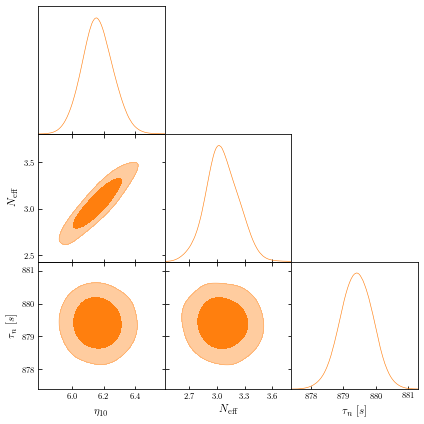

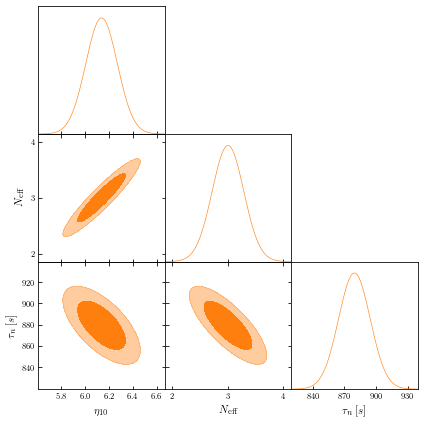

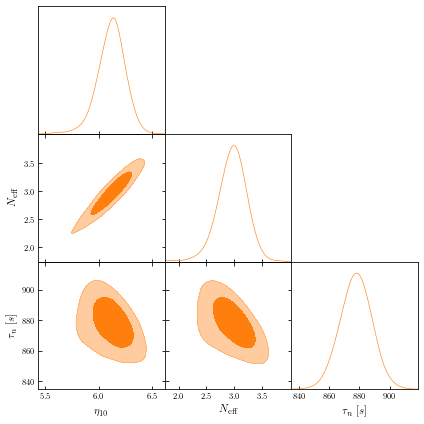

In [386]:
gdplot.triangle_plot(gdsExact, gparams, filled=True, colors=myColors, contour_colors=myColors)
# gdplot.triangle_plot(gdsFisher, params, filled=True, colors=myColors, contour_colors=myColors)

gdplot.triangle_plot(aFisher, gparams, filled=True, colors=myColors, contour_colors=myColors)

gdplot.triangle_plot(gdsDali, gparams, filled=True, colors=myColors, contour_colors=myColors)

## Finalize

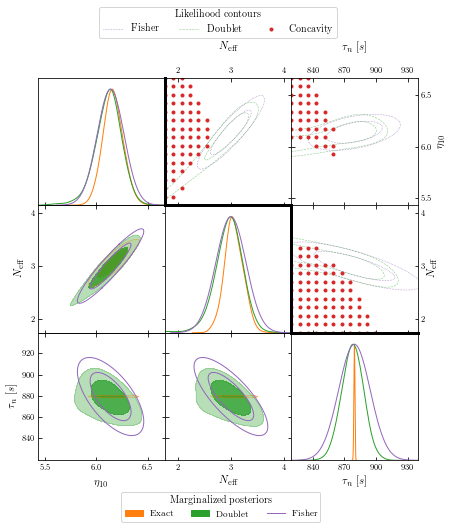

In [387]:
contour_line_widths = [1,1,1]
contour_widths = [0.6,0.6,0.6]

# self.solid_colors = ['#006FED', '#E03424', 'gray', '#009966', '#000866', '#336600', '#006633', 'm', 'r']
# self.alpha_filled_add = 0.85
# self.alpha_factor_contour_lines = 0.5

#gdplot.triangle_plot([gdsDali, gdsDali, aFisher], gparams, filled=[True, True, False], colors=myColors, contour_colors=myColors, contour_lws=contour_line_widths, legend_ncol=3)
gdplot.triangle_plot([gdsExact, gdsDali, aFisher], gparams, filled=[True, True, False], colors=myColors, contour_colors=myColors, contour_lws=contour_line_widths, legend_ncol=3)

xbounds = [gdplot.get_axes((0,0)).get_xlim(), gdplot.get_axes((1,1)).get_xlim(), gdplot.get_axes((2,2)).get_xlim()]
add_KBBN(gdplot, bounds=xbounds, plot_order=[[1,0], [2,0], [2,1]], contour_levels = [0, 2.3, 6.17], lws=contour_widths, alphas=[1, 0.5, 1])

#Clean up time
a: Axes = gdplot.get_axes((0,1))
b: Axes = gdplot.get_axes((0,2))
c: Axes = gdplot.get_axes((1,2))

# add bars to seperate the curvature from posteriors
bar_thickness = 3.0
a.spines['left'].set_linewidth(bar_thickness)
a.spines['bottom'].set_linewidth(bar_thickness)
c.spines['left'].set_linewidth(bar_thickness)
c.spines['bottom'].set_linewidth(bar_thickness)

#fix ticks and labels
a.tick_params(axis='both', direction = 'in', labeltop = True, labelbottom = False, labelleft = False, labelright = False, top=True, bottom=True, left=False, right=True)
b.tick_params(axis='both', direction = 'in', labeltop = True, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=True, right=True)
c.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=False, right=True)

a.get_xaxis().set_label_position('top')
a.get_yaxis().set_label_position('right')
b.get_xaxis().set_label_position("top")
b.get_yaxis().set_label_position("right")
c.get_yaxis().set_label_position("right")
c.set_xlabel('')

#fix the tick labels
a.set_xticks(gdplot.get_axes((1,1)).get_xticks())
b.set_xticks(gdplot.get_axes((2,2)).get_xticks())
c.set_xticks(gdplot.get_axes((2,2)).get_xticks())

a.set_yticks(gdplot.get_axes((0,0)).get_xticks())
b.set_yticks(gdplot.get_axes((0,0)).get_xticks())
c.set_yticks(gdplot.get_axes((1,1)).get_xticks())

# legends
gdplot.legend.set_bbox_to_anchor((0.75, 0.015), transform=gdplot.fig.transFigure)
gdplot.legend.set_title('Marginalized posteriors')

# Top left
# legend_2 = c.legend(ncol=2, bbox_to_anchor=(0.4, 1.1), bbox_transform=gdplot.fig.transFigure)
# Top Center
legend_2 = c.legend(ncol=3, bbox_to_anchor=(0.8, 1.15), bbox_transform=gdplot.fig.transFigure)
#bottom center
#legend_2 = c.legend(ncol=3, bbox_to_anchor=(0, -0.15), bbox_transform=gdplot.fig.transFigure)
legend_2.set_title('Likelihood contours')

# fix overlapping of curvature points on some borders
for ax in [a,b,c]:
    for k, spine in ax.spines.items():
        spine.set_zorder(10)

if save_pdf:
    # export wasn't adjusting overall figure size to fit the curvature legend, so we do it manually
    # gdplot.export(job + '.pdf')
    gdplot.fig.savefig(f'{job}_t{tau_prior}.pdf', bbox_extra_artists=gdplot.extra_artists + [legend_2], bbox_inches='tight')